In [2]:
import os
import gc
import sys
import torch
import psutil
import pickle
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn import metrics
from collections import Counter
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import models, set_image_backend
import data_utils
import train_utils
import model_utils
import argparse


class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

state_dict_file = '/n/tcga_models/resnet18_WGD_all_10x.pt'
input_size = 2048
hidden_size = 512
output_size = 1

# initialize trained resnet
resnet = models.resnet18(pretrained=False)
resnet.fc = nn.Linear(2048, output_size, bias=True)
saved_state = torch.load(state_dict_file, map_location=lambda storage, loc: storage)
resnet.load_state_dict(saved_state)
resnet.fc = Identity()
device = torch.device('cuda',1)
resnet.cuda(device=device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [4]:
val_cancers = ['COAD', 'BRCA', 'READ_10x', 'LUSC_10x', 'BLCA_10x', 'LUAD_10x', 'STAD_10x', 'HNSC_10x','UCEC', 'LIHC_10x', 'KIRC_10x']
root_dir = '/n/mounted-data-drive/'
magnification = '10.0'
criterion=nn.BCEWithLogitsLoss()

In [5]:
pickle_file = '/home/sxchao/MSI_prediction/tcga_project/tcga_wgd_sa_all.pkl'
batch_all, _, _, sa_trains, sa_vals = data_utils.load_COAD_train_val_sa_pickle(pickle_file=pickle_file,
                                                                               return_all_cancers=True, 
                                                                               split_in_two=True)
val_transform = train_utils.transform_validation

In [6]:
val_sets = []
for j in range(len(val_cancers)):
    val_set = data_utils.TCGADataset_tiles(sa_vals[batch_all.index(val_cancers[j])], 
                                           root_dir + val_cancers[j] + '/', 
                                           transform=val_transform, 
                                           magnification=magnification, 
                                           batch_type='tile', 
                                           return_jpg_to_sample=True)
    val_sets.append(val_set)

In [7]:
val_loaders = [torch.utils.data.DataLoader(val_set, 
                                            batch_size=400, 
                                            shuffle=True, 
                                            num_workers=12, 
                                            pin_memory=True,drop_last=True) for val_set in val_sets]

In [8]:
embeddings = dict()
for cancer in val_cancers:
    embeddings[cancer] = []

In [23]:
for idx,cancer in enumerate(val_cancers):
    val_loader = val_loaders[idx]
    embeds_cancer = []
    print(cancer)
    for step, (batch,labels,jpg_to_sample) in enumerate(val_loader):
        with torch.no_grad():
            inputs = batch.cuda(device=device)
            e = resnet(inputs)
            embeds_cancer.extend(e.detach().cpu().numpy())
            if step % 50 ==0 and step>0:
                print(step,end=' ')
                break
    embeddings[cancer] = np.stack(embeds_cancer)

COAD
50 BRCA
50 READ_10x
50 LUSC_10x
50 BLCA_10x
50 LUAD_10x
50 STAD_10x
50 HNSC_10x
50 UCEC
50 LIHC_10x
50 KIRC_10x
50 

In [26]:
all_embedings = np.concatenate([embeddings[cancer] for cancer in val_cancers])

In [28]:
from sklearn.decomposition import PCA
pc = PCA(10,whiten=True)

In [29]:
pc_counts = pc.fit_transform(all_embedings)

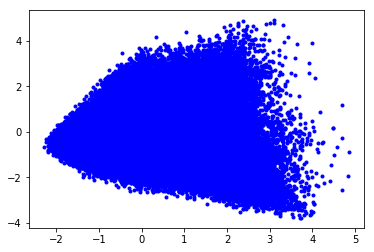

In [30]:
plt.plot(pc_counts[:,0],pc_counts[:,1],'b.')

In [31]:
pc.explained_variance_ratio_

array([0.09892608, 0.0502978 , 0.04606417, 0.0338222 , 0.03149856,
       0.02558287, 0.02227569, 0.02174099, 0.01923624, 0.01651933])

In [36]:
import umap

In [37]:
embedding = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(pc_counts)

In [38]:
import seaborn as sns

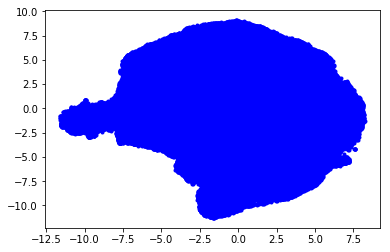

In [40]:
plt.plot(embedding[:,0],embedding[:,1],'b.')

In [41]:
len(embeddings[cancer])

20400

In [42]:
hue=np.zeros(embedding.shape[0])

In [43]:
for i in range(11):
    hue[20400*i:(i+1)*20400] = i

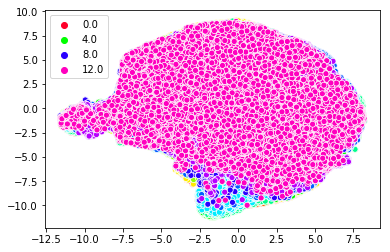

In [46]:
sns.scatterplot(x=embedding[:,0],y=embedding[:,1],hue=hue,palette='gist_rainbow')